In [255]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm,skew,kurtosis,t,ttest_1samp
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns

## Problem 1

In [256]:
# Set sample size and repeated times
sample_size = 100
samples = 1000

In [257]:
# Calculate kurtosis and skewness for samples
d = norm(0,1)
kurts =[]
skews= []
for i in range(samples):
    kurts.append(kurtosis(d.rvs(sample_size)))
    skews.append(skew(d.rvs(sample_size)))

In [258]:
# Get sample mean, sample deviation for skewness and kurtosis
k_hat = np.mean(kurts)
k_std = math.sqrt(np.var(kurts,ddof =1))
s_hat = np.mean(skews)
s_std = math.sqrt(np.var(skews,ddof =1))

In [259]:
# Perform manual t Test
# t test for kurtosis
t_stat_k = k_hat/(k_std/math.sqrt(samples))
p_k = 2*(1-t.cdf(abs(t_stat_k),df = samples-1))
print("t stat for kurtosis : {}".format(t_stat_k))
print("p value for kurtosis : {}".format(p_k))
# t test for skewness
t_stat_s = s_hat/(s_std/math.sqrt(samples))
p_s = 2*(1-t.cdf(abs(t_stat_s),df = samples-1))
print("t stat for skewness : {}".format(t_stat_s))
print("p value for skewness : {}".format(p_s))

t stat for kurtosis : -4.052287847916047
p value for kurtosis : 5.465494938294846e-05
t stat for skewness : 1.0206484318934486
p value for skewness : 0.30766813311970775


In [260]:
# Perform included t Test
kurt_result = ttest_1samp(kurts,popmean = 0, alternative ='two-sided')
print("t stat for kurtosis : {}".format(kurt_result[0]))
print("p value for kurtosis : {}".format(kurt_result[1]))
skew_result = ttest_1samp(skews,popmean = 0, alternative ='two-sided')
print("t stat for skewness : {}".format(skew_result[0]))
print("p value for skewness : {}".format(skew_result[1]))

t stat for kurtosis : -4.052287847916047
p value for kurtosis : 5.465494938307592e-05
t stat for skewness : 1.0206484318934483
p value for skewness : 0.3076681331197079


## Problem2

### OLS

In [112]:
# Read in data from csv
data = pd.read_csv("problem2.csv")
# create vector for X and Y
X = data.iloc[:,0].to_numpy()
Y = data.iloc[:,1].to_numpy()

In [268]:
# Calculate OLS by hand
# Add 1 before the original x vector
x = np.column_stack((np.ones(len(X)),X))
x_t = np.transpose(x)
beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_t,x)),x_t),Y)
e = Y- np.matmul(x,beta)

In [277]:
# Fit included OLS
model = sm.OLS(Y,X).fit()
# print(model.summary())
error = Y - model.predict(X)
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.193
Model:                            OLS   Adj. R-squared (uncentered):              0.185
Method:                 Least Squares   F-statistic:                              23.69
Date:                Fri, 27 Jan 2023   Prob (F-statistic):                    4.28e-06
Time:                        00:21:21   Log-Likelihood:                         -160.49
No. Observations:                 100   AIC:                                      323.0
Df Residuals:                      99   BIC:                                      325.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [270]:
# Calculate the skewness and kurtosis of error vector
print("Skewness of error: {}".format(skew(e)))
print("kurtosis of error: {}".format(kurtosis(e)))
# Compare with the included OLS
print("Skewness of error: {}".format(skew(error)))
print("kurtosis of error: {}".format(kurtosis(error)))

Skewness of error: -0.267266585528796
kurtosis of error: 3.1931010009568777
Skewness of error: -0.26725989185266363
kurtosis of error: 3.193130358863356


In [274]:
print("Beta for OLS",beta)

Beta for OLS [0.1198362  0.60520482]


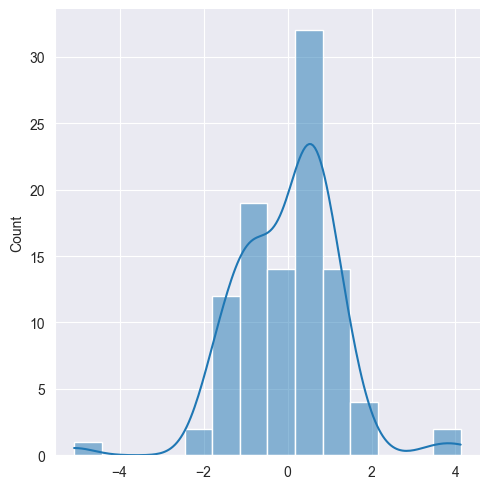

In [265]:
# Plot the distribution of error
sns.displot(e, kde=True)

### MLE: Normal

In [272]:
# ll for normal
def mle_norm(s_b_array):
    # First extract s and beta from the parameter passed in
    s = s_b_array[0]
    b = np.transpose(s_b_array[1:])
    n = len(Y)
    xm = Y - np.matmul(x,b)
    s2 = s*s
    ll = -n/2 * math.log(s2*2*math.pi)-np.matmul(np.transpose(xm),xm)/(2*s2)
    # return abs of ll because I used minimize below
    return -ll

In [273]:
#Optimization
ll_normal = minimize(mle_norm,[1,1,2])
# Result
print("Normal betas:",ll_normal.x[1:])
print("Normal s:{}".format(ll_normal.x[0]))
ll_result = -mle_norm(ll_normal.x)
print("Normal ll:{}".format(ll_result))
aic_normal = 2*(1+1+1)- 2*ll_result
print("Normal AIC:{}".format(aic_normal))
bic_normal = 3*math.log(len(Y))-2*ll_result
print("Normal BIC:{}".format(bic_normal))

Normal betas: [0.11983622 0.60520483]
Normal s:1.1983941337778061
Normal ll:-159.99209668916234
Normal AIC:325.9841933783247
Normal BIC:333.79970393628895


### MLE: T distribution

In [275]:
def ll_t(s_n_b_array):
    # First extract s, nu,beta from the parameter passed in
    s = s_n_b_array[0]
    nu = s_n_b_array[1]
    b = s_n_b_array[2:]
    xm = Y - x @ b
    # use the logpdf built-in function of t
    ll = t.logpdf(xm,nu,0,s).sum()
    return -ll

In [276]:
#Optimization
ll_t_res = minimize(ll_t,[1,3,1,2])
# Result
print("T betas:",ll_t_res.x[2:])
print("T s:{}".format(ll_t_res.x[0]))
print("T df:{}".format(ll_t_res.x[1]))
ll_t_max = -ll_t(ll_t_res.x)
print("T ll:{}".format(ll_t_max))
aic_t = 2*4- 2*ll_t_max
print("T AIC:{}".format(aic_t))
bic_t = 4*math.log(len(Y))-2*ll_t_max
print("T BIC:{}".format(bic_t))

T betas: [0.14261413 0.55757229]
T s:0.9712662060582071
T df:6.276576295253262
T ll:-155.47297041249448
T AIC:318.94594082498895
T BIC:329.3666215689413


## Problem 3

Simulate MA process

In [278]:
#Set parameters: mu=1, theta = 0.5, sigma = 0.1 , e ~ N(0,0.1)
mu=1
theta =0.5
sigma = 0.1
n = 1000
burn_in =50

In [279]:
# MA(1)
#y_t = 1+ e_t + 0.5*e_t-1
y_ma1 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(1,n+burn_in):
    y_t = mu+e[i]+ theta * e[i-1]
    if i >= burn_in:
        y_ma1[i-burn_in] =y_t

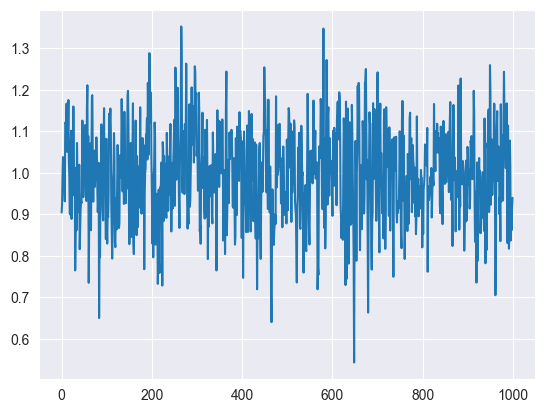

In [280]:
# Plot MA(1)
plt.plot(y_ma1)

In [281]:
# Fit the simulated data using python ARIMA model
ma1_fit = sm.tsa.arima.ARIMA(y_ma1, order=(0, 0, 1))
res = ma1_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 875.538
Date:                Fri, 27 Jan 2023   AIC                          -1745.075
Time:                        00:44:40   BIC                          -1730.352
Sample:                             0   HQIC                         -1739.480
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9973      0.005    210.774      0.000       0.988       1.007
ma.L1          0.4805      0.028     17.286      0.000       0.426       0.535
sigma2         0.0102      0.000     23.271      0.0

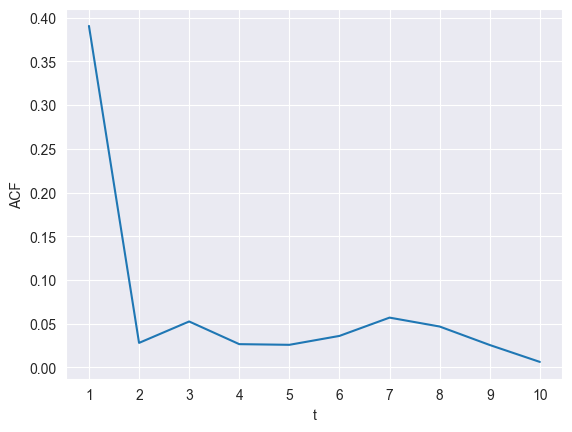

In [282]:
# Show Plot of ACF
acf_ma1 = sm.tsa.stattools.acf(y_ma1)
plt.plot(np.arange(1,11),acf_ma1[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

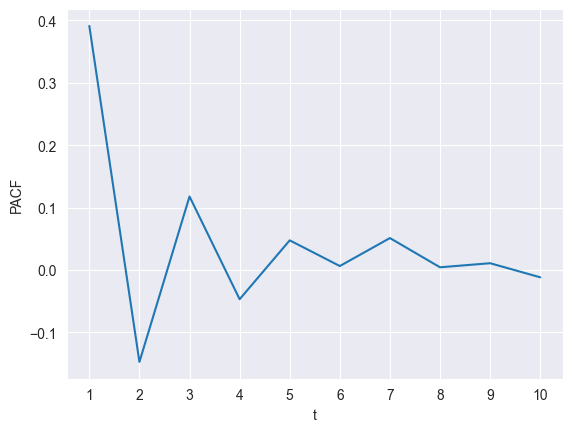

In [283]:
# Show Plot of PACF
pacf_ma1 = sm.tsa.stattools.pacf(y_ma1)
plt.plot(np.arange(1,11),pacf_ma1[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()

In [284]:
# MA(2)
theta2 = 0.25
#y_t = 1+ e_t + 0.5*e_t-1 + 0.25* e_t-2
y_ma2 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(2,n+burn_in):
    y_t = mu+e[i]+ theta * e[i-1] + theta2 * e[i-2]
    if i >= burn_in:
        y_ma2[i-burn_in] =y_t

In [285]:
# Fit the simulated data using python ARIMA model
ma2_fit = sm.tsa.arima.ARIMA(y_ma2, order=(0, 0, 2))
res = ma2_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 902.343
Date:                Fri, 27 Jan 2023   AIC                          -1796.685
Time:                        00:45:34   BIC                          -1777.054
Sample:                             0   HQIC                         -1789.224
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0016      0.005    190.579      0.000       0.991       1.012
ma.L1          0.4739      0.031     15.451      0.000       0.414       0.534
ma.L2          0.2146      0.030      7.141      0.0

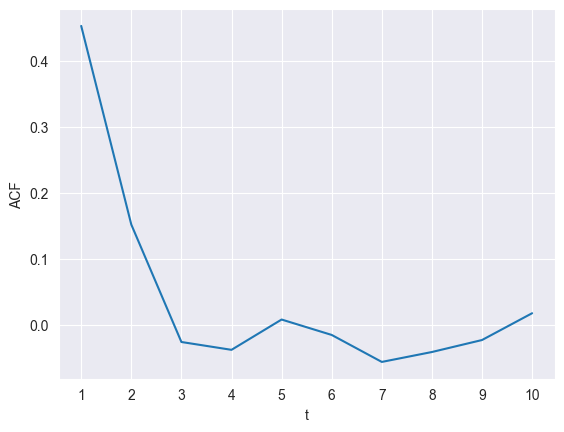

In [286]:
# Show Plot of ACF
acf_ma2 = sm.tsa.stattools.acf(y_ma2)
plt.plot(np.arange(1,11),acf_ma2[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

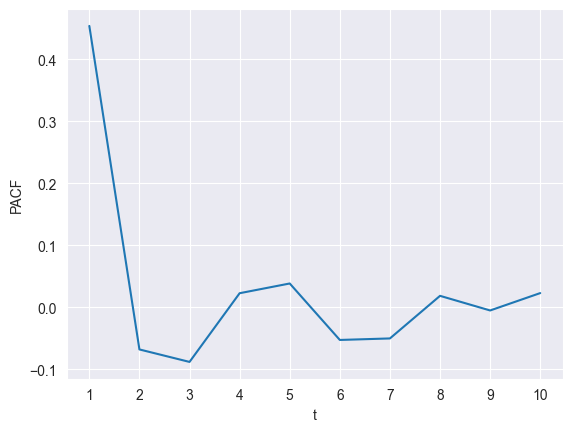

In [287]:
# Show Plot of PACF
pacf_ma2 = sm.tsa.stattools.pacf(y_ma2)
plt.plot(np.arange(1,11),pacf_ma2[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()

In [288]:
# MA(3)
theta3 = 0.2
#y_t = 1+ e_t + 0.5*e_t-1 + 0.25* e_t-2 + 0.2 * e_t-3
y_ma3 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(3,n+burn_in):
    y_t = mu+e[i]+ theta * e[i-1] + theta2 * e[i-2] + theta3 * e[i-3]
    if i >= burn_in:
        y_ma3[i-burn_in] =y_t

In [289]:
# Fit the simulated data using python ARIMA model
ma3_fit = sm.tsa.arima.ARIMA(y_ma3, order=(0, 0, 3))
res = ma3_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 876.345
Date:                Fri, 27 Jan 2023   AIC                          -1742.690
Time:                        00:46:14   BIC                          -1718.151
Sample:                             0   HQIC                         -1733.363
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9977      0.006    162.308      0.000       0.986       1.010
ma.L1          0.5029      0.031     16.392      0.000       0.443       0.563
ma.L2          0.2050      0.035      5.892      0.0

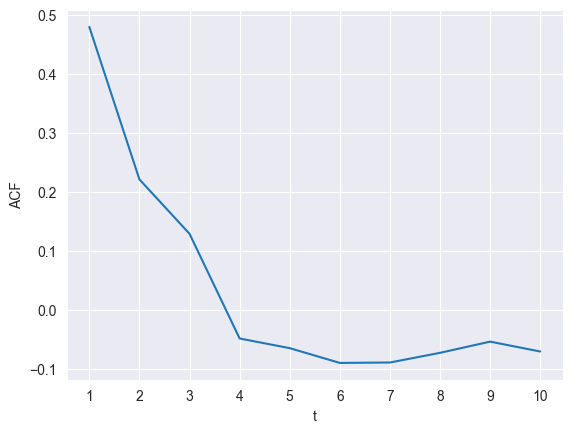

In [290]:
# Show Plot of ACF
acf_ma3 = sm.tsa.stattools.acf(y_ma3)
plt.plot(np.arange(1,11),acf_ma3[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

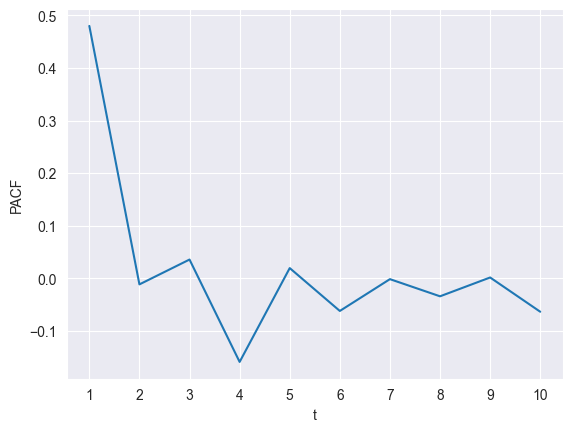

In [291]:
# Show Plot of PACF
pacf_ma3 = sm.tsa.stattools.pacf(y_ma3)
plt.plot(np.arange(1,11),pacf_ma3[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()

simulate AR process

In [292]:
#Set parameters: mu=1,sigma = 0.1 , e ~ N(0,0.1)
mu=1
b1 =0.5
sigma = 0.1
n = 1000
burn_in =50

In [293]:
# AR(1)
#y_t = 1.0 + 0.5*y_t-1 + e, e ~ N(0,0.1)
yt_last = 1
y_ar1 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(1,n+burn_in):
    y_t = mu + b1 * yt_last + e[i]
    yt_last = y_t
    if i >= burn_in:
        y_ar1[i-burn_in] =y_t

In [294]:
# Fit the simulated data using python ARIMA model
ar1_fit = sm.tsa.arima.ARIMA(y_ar1, order=(1, 0, 0))
res = ar1_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 865.087
Date:                Fri, 27 Jan 2023   AIC                          -1724.174
Time:                        00:57:41   BIC                          -1709.450
Sample:                             0   HQIC                         -1718.578
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0042      0.006    310.646      0.000       1.992       2.017
ar.L1          0.5006      0.028     17.784      0.000       0.445       0.556
sigma2         0.0104      0.000     22.446      0.0

/Users/cuiwenjie/Desktop/Spring2023/Fintech545/hw_545/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


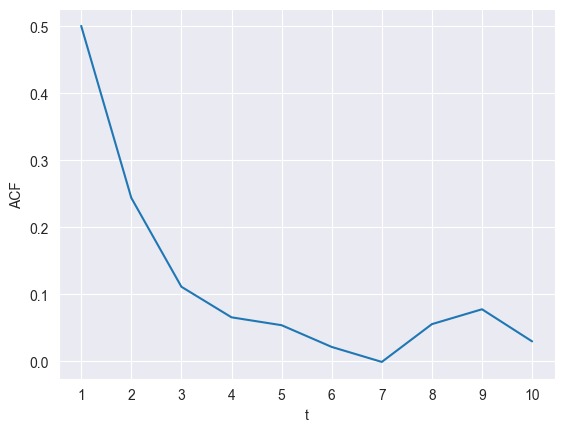

In [295]:
# Show Plot of ACF
acf_ar1 = sm.tsa.stattools.acf(y_ar1)
plt.plot(np.arange(1,11),acf_ar1[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

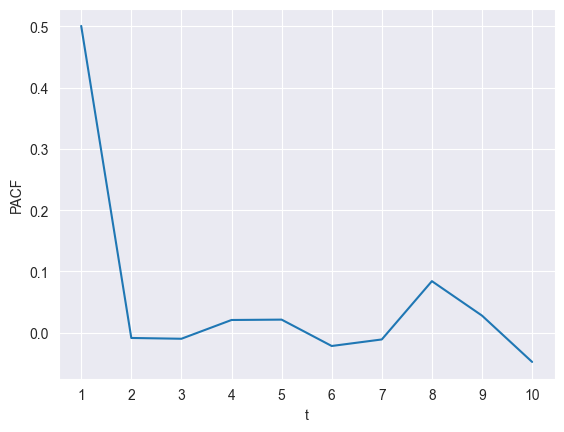

In [296]:
# Show Plot of PACF
pacf_ar1 = sm.tsa.stattools.pacf(y_ar1)
plt.plot(np.arange(1,11),pacf_ar1[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()

In [297]:
# AR(2)
b2=0.25
#y_t = 1.0 + 0.5*y_t-1 + 0.25*y_t-2 + e, e ~ N(0,0.1)
yt_last = [1,1]
y_ar2 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(1,n+burn_in):
    y_t = mu + b1 * yt_last[0] + b2 * yt_last[1] +e[i]
    yt_last[1] = yt_last[0]
    yt_last[0] = y_t
    if i >= burn_in:
        y_ar2[i-burn_in] =y_t

In [298]:
# Fit the simulated data using python ARIMA model
ar2_fit = sm.tsa.arima.ARIMA(y_ar2, order=(2, 0, 0))
res = ar2_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 889.812
Date:                Fri, 27 Jan 2023   AIC                          -1771.625
Time:                        00:58:20   BIC                          -1751.994
Sample:                             0   HQIC                         -1764.163
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9887      0.014    292.985      0.000       3.962       4.015
ar.L1          0.4921      0.031     16.102      0.000       0.432       0.552
ar.L2          0.2759      0.030      9.269      0.0

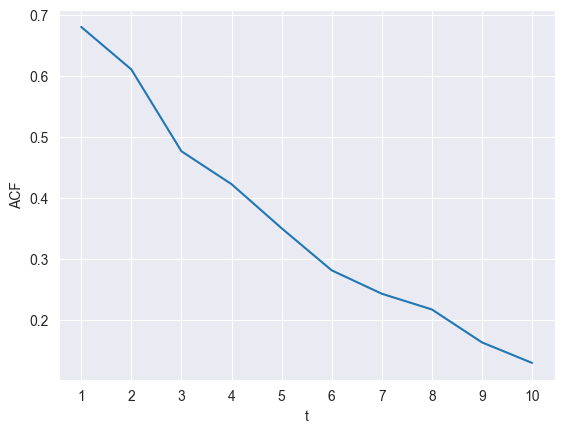

In [301]:
# Show Plot of ACF
acf_ar2 = sm.tsa.stattools.acf(y_ar2)
plt.plot(np.arange(1,11),acf_ar2[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

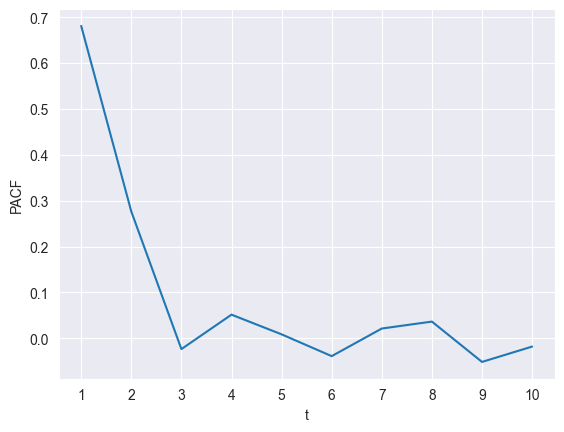

In [300]:
# Show Plot of PACF
pacf_ar2 = sm.tsa.stattools.pacf(y_ar2)
plt.plot(np.arange(1,11),pacf_ar2[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()

In [302]:
# AR(3)
b3=0.1
#y_t = 1.0 + 0.5*y_t-1 + 0.25*y_t-2 + 0.1*y_t-3+ e, e ~ N(0,0.1)
yt_last = [1,1,1]
y_ar3 = np.zeros(n)
e=np.random.normal(0.0,sigma,n+burn_in)
for i in range(1,n+burn_in):
    y_t = mu + b1 * yt_last[0] + b2 * yt_last[1] + b3 * yt_last[2]+e[i]
    yt_last[2] = yt_last[1]
    yt_last[1] = yt_last[0]
    yt_last[0] = y_t
    if i >= burn_in:
        y_ar3[i-burn_in] =y_t

In [303]:
# Fit the simulated data using python ARIMA model
ar3_fit = sm.tsa.arima.ARIMA(y_ar3, order=(3, 0, 0))
res = ar3_fit.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 912.382
Date:                Fri, 27 Jan 2023   AIC                          -1814.763
Time:                        01:02:12   BIC                          -1790.224
Sample:                             0   HQIC                         -1805.437
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6856      0.022    308.972      0.000       6.643       6.728
ar.L1          0.5250      0.032     16.628      0.000       0.463       0.587
ar.L2          0.2765      0.034      8.062      0.0

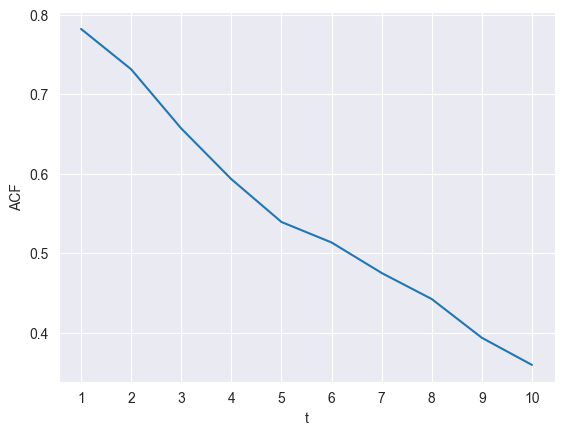

In [304]:
# Show Plot of ACF
acf_ar3 = sm.tsa.stattools.acf(y_ar3)
plt.plot(np.arange(1,11),acf_ar3[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("ACF")
plt.show()

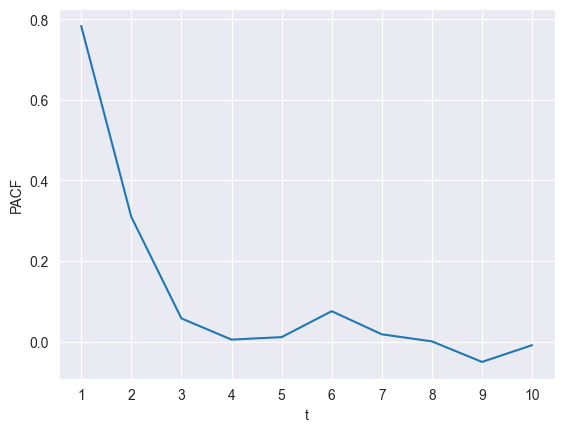

In [305]:
# Show Plot of PACF
pacf_ar3 = sm.tsa.stattools.pacf(y_ar3)
plt.plot(np.arange(1,11),pacf_ar3[1:11])
plt.xticks(np.arange(1,11))
plt.xlabel("t")
plt.ylabel("PACF")
plt.show()